In [1]:
import cv2
import numpy as np
import os
import torch
import torch.nn.functional as F
from torchvision.transforms import Compose
from tqdm import tqdm

from depth_anything.dpt import DepthAnything
from depth_anything.util.transform import Resize, NormalizeImage, PrepareForNet

import matplotlib.pyplot as plt

In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [3]:
depth_anything = DepthAnything.from_pretrained('LiheYoung/depth_anything_{}14'.format('vitb')).to(DEVICE).eval()
    
total_params = sum(param.numel() for param in depth_anything.parameters())
print('Total parameters: {:.2f}M'.format(total_params / 1e6))
    
transform = Compose([
    Resize(
        width=518,
        height=518,
        resize_target=False,
        keep_aspect_ratio=True,
        ensure_multiple_of=14,
        resize_method='lower_bound',
        image_interpolation_method=cv2.INTER_CUBIC,
    ),
    NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    PrepareForNet(),
])

Total parameters: 97.47M


In [4]:
def get_depth(img: np.ndarray) -> np.ndarray:
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0

    h, w = image.shape[:2]
    
    image = transform({'image': image})['image']
    plt.imshow(image[0])
    image = torch.from_numpy(image).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        depth = depth_anything(image)

    depth = F.interpolate(depth[None], (h, w), mode='bilinear', align_corners=False)[0, 0]
    depth = (depth - depth.min()) / (depth.max() - depth.min()) * 255.0
        
    depth = depth.cpu().numpy().astype(np.uint8)

    #return depth
    return np.repeat(depth[..., np.newaxis], 3, axis=-1)

In [5]:
img_pose_file = "/home/jason/ROS/bags/analysis/pose.txt"
img_pose = list()

f = open(img_pose_file, "r")
content = f.readlines()

In [6]:
frame1 = content[75].split(',')
frame2 = content[76].split(',')

frame1_pose = (float(frame1[1]), float(frame1[2]), float(frame1[3]))
frame1_img = frame1[0]

frame2_pose = (float(frame2[1]), float(frame2[2]), float(frame2[3]))
frame2_img = frame2[0]

In [7]:
img1 = cv2.imread("/home/jason/ROS/bags/images/wp_ground/"+frame1_img)
img2 = cv2.imread("/home/jason/ROS/bags/images/wp_ground/"+frame2_img)

pose_change = (frame1_pose[0]-frame2_pose[0],
               frame1_pose[1]-frame2_pose[1],
               frame1_pose[2]-frame2_pose[2])
pose_change

(0.10934988782966126, 0.2349110031676913, 0.014778104339624676)

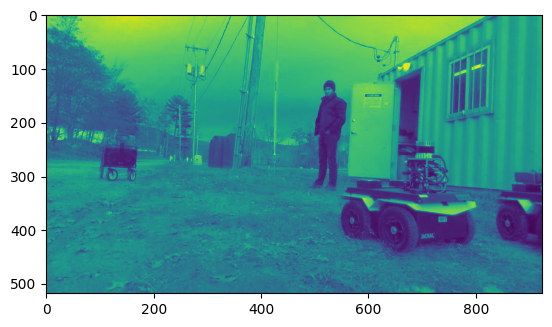

In [8]:
depth1 = get_depth(img1)
depth2 = get_depth(img2)

<Figure size 640x480 with 0 Axes>

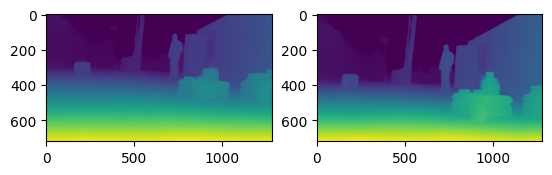

In [9]:
plt.figure()

f, ax = plt.subplots(1,2)

ax[0].imshow(depth1[:,:,0])
ax[1].imshow(depth2[:,:,0])

### Notes/ Ideas

- Recover $\lambda$ and $\mu$ depth parameters using SFM? And from there we can know the rest based on the depth map form DA. We need scale and camera intrinsics.

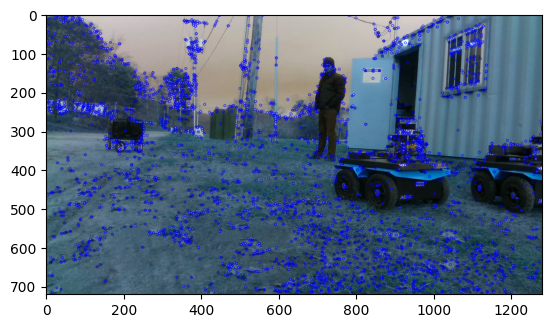

In [10]:
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

#use flann to perform feature matching
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1,des2,k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

if len(good)>10:
    p1 = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    p2 = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
img3 = cv2.drawKeypoints(img1, kp1, 0, (0,0,255))
plt.imshow(img3)


In [11]:
# set intrinsics
k_input = [879.2263626388094, 879.3081232332211, 629.0191606917964, 350.9911507351595]

K = np.diag((k_input[0], k_input[1], 1))
K[0,2], K[1,2] = k_input[2], k_input[3]

print("intrinsics:\n", K)

intrinsics:
 [[879.22636264   0.         629.01916069]
 [  0.         879.30812323 350.99115074]
 [  0.           0.           1.        ]]


In [12]:
# get E from matches
E, mask = cv2.findEssentialMat(p1, p2, K, cv2.RANSAC, 0.999, 1.0);
matches_mask = mask.ravel().tolist()

points, R, t, mask = cv2.recoverPose(E, p1, p2)
#print("R: ", R, "\nt: ", t)

M_r = np.hstack((R, t))
M_l = np.hstack((np.eye(3, 3), np.zeros((3, 1))))

P_l = K @ M_l
P_r = K @ M_r

# undistort points
p1 = p1[np.asarray(matches_mask)==1,:,:]
p2 = p2[np.asarray(matches_mask)==1,:,:]
#p1_un = cv2.undistortPoints(p1,K,None)
#p2_un = cv2.undistortPoints(p2,K,None)
p1_un = np.squeeze(p1)
p2_un = np.squeeze(p2)

#triangulate points this requires points in normalized coordinate
point_4d_hom = cv2.triangulatePoints(P_l, P_r, p1_un.T, p2_un.T)
#print(point_4d_hom.shape, p1_un.shape)
point_3d = point_4d_hom / np.tile(point_4d_hom[-1, :], (4, 1))
point_3d = point_3d[:3, :].T
#print(point_3d.shape)


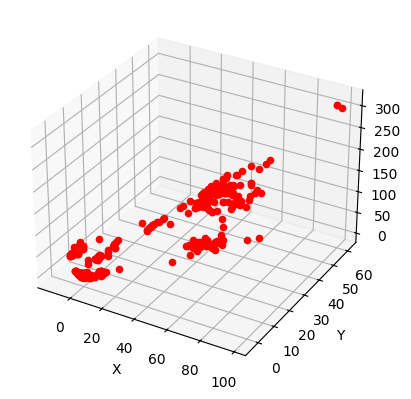

In [13]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

for x, y, z in point_3d:
    ax.scatter(x, y, abs(z), c="r", marker="o")
ax.scatter(0,0,0, c='b', marker='o')

In [14]:
p1_tmp = np.ones([3, p1.shape[0]])
p1_tmp[:2,:] = np.squeeze(p1).T
p2_tmp = np.ones([3, p2.shape[0]])
p2_tmp[:2,:] = np.squeeze(p2).T
print((np.dot(R, p2_tmp) + t) - p1_tmp)

[[ -0.52734217   1.29193917  -0.29738278 ...  74.06114217  81.09382462
   82.09271004]
 [ 70.63198547  69.92820162  70.4969972  ...  63.38208464  64.98946257
   67.06828977]
 [-24.3820069  -23.25052576 -24.06657888 ... -31.08346135 -32.03177475
  -33.13452183]]


In [15]:
# put the depth in the image
p1_zip = zip(p1_un,point_3d)
p2_zip = zip(p2_un,point_3d)

p1_depth = np.zeros((p1_un.shape[0],3), dtype=np.float32)
p2_depth = np.zeros((p1_un.shape[0],3), dtype=np.float32)

i = 0
for im, p3d in zip(p1_un, point_3d):
    #print(im,p3d)
    d = np.linalg.norm(p3d)
    p1_depth[i] = np.array([int(im[0]),int(im[1]),d])
    i += 1

i = 0
for im, p3d in zip(p2_un, point_3d):
    #print(im,p3d)
    d = np.linalg.norm(p3d)
    p2_depth[i] = np.array([int(im[0]),int(im[1]),d])
    i += 1

print(p1_depth[0])
print(p2_depth[0])

[ 35.     250.     124.9352]
[ 33.     321.     124.9352]


In [16]:
# now relate this to the depth anything map
# we have absolute depth for some key points
# relative depth for every point
